In [13]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
from pts.dataset import to_pandas, MultivariateGrouper, TrainDatasets
from pts.dataset.repository import get_dataset, dataset_recipes
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from pts.evaluation import make_evaluation_predictions
from pts.evaluation import MultivariateEvaluator

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare data set

In [6]:
dataset = get_dataset("solar_nips", regenerate=False, shuffle=False)

In [37]:
train_series = next(iter(dataset.train))
to_pandas(train_series)

2006-01-01 00:00:00    0.0
2006-01-01 01:00:00    0.0
2006-01-01 02:00:00    0.0
2006-01-01 03:00:00    0.0
2006-01-01 04:00:00    0.0
                      ... 
2006-10-19 20:00:00    0.0
2006-10-19 21:00:00    0.0
2006-10-19 22:00:00    0.0
2006-10-19 23:00:00    0.0
2006-10-20 00:00:00    0.0
Freq: H, Length: 7009, dtype: float32

In [36]:
test_series = next(iter(dataset.test))
to_pandas(test_series)

2006-01-01 00:00:00    0.0
2006-01-01 01:00:00    0.0
2006-01-01 02:00:00    0.0
2006-01-01 03:00:00    0.0
2006-01-01 04:00:00    0.0
                      ... 
2006-10-20 20:00:00    0.0
2006-10-20 21:00:00    0.0
2006-10-20 22:00:00    0.0
2006-10-20 23:00:00    0.0
2006-10-21 00:00:00    0.0
Freq: H, Length: 7033, dtype: float32

In [39]:
len(dataset.train)

137

In [33]:
len(dataset.test)

959

In [7]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [17]:
dataset.metadata.feat_static_cat[0]

CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')

In [51]:
len(dataset.test)

959

In [8]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [9]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

c:\users\niels.rogge\documents\python projecten\howest\pytorch-ts\pts\dataset\multivariate_grouper.py:175: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


In [43]:
ts = next(iter(dataset_train))
ts

{'target': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'start': Timestamp('2006-01-01 00:00:00', freq='H'),
 'feat_static_cat': array([0], dtype=int64),
 'source': SourceContext(source='list_data', row=1)}

In [45]:
len(dataset_train)

1

In [44]:
train_series = next(iter(dataset.train))
train_series

{'start': Timestamp('2006-01-01 00:00:00', freq='H'),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'feat_static_cat': array([0], dtype=int64),
 'item_id': 0,
 'source': SourceContext(source='C:\\Users\\niels.rogge\\.pytorch\\pytorch-ts\\datasets\\solar_nips\\train\\data.json', row=1)}

In [46]:
len(dataset.train)

137

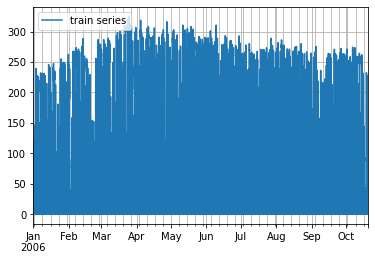

In [14]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

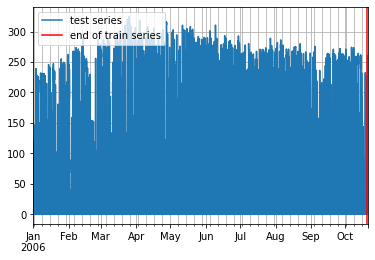

In [19]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [20]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: H


In [25]:
len(dataset.train)

137

In [26]:
len(dataset.test)

959

## Evaluator

In [10]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `GRU-Real-NVP`

In [45]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    n_blocks=4,
    trainer=Trainer(device=device,
                    epochs=45,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [46]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:10,  9.03it/s, avg_epoch_loss=-43.1, epoch=0]
99it [00:10,  9.03it/s, avg_epoch_loss=-126, epoch=1]
99it [00:11,  9.00it/s, avg_epoch_loss=-142, epoch=2]
99it [00:10,  9.37it/s, avg_epoch_loss=-143, epoch=3]
99it [00:10,  9.09it/s, avg_epoch_loss=-153, epoch=4]
99it [00:11,  8.76it/s, avg_epoch_loss=-157, epoch=5]
99it [00:10,  9.03it/s, avg_epoch_loss=-157, epoch=6]
99it [00:11,  8.94it/s, avg_epoch_loss=-166, epoch=7]
99it [00:11,  8.56it/s, avg_epoch_loss=-169, epoch=8]
99it [00:11,  8.84it/s, avg_epoch_loss=-168, epoch=9]
98it [00:11,  8.89it/s, avg_epoch_loss=-170, epoch=10]
99it [00:11,  8.89it/s, avg_epoch_loss=-172, epoch=11]
98it [00:10,  9.00it/s, avg_epoch_loss=-172, epoch=12]
99it [00:10,  9.02it/s, avg_epoch_loss=-177, epoch=13]
99it [00:10,  9.48it/s, avg_epoch_loss=-180, epoch=14]
98it [00:10,  9.65it/s, avg_epoch_loss=-180, epoch=15]
99it [00:10,  9.01it/s, avg_epoch_loss=-182, epoch=16]
99it [00:10,  9.11it/s, avg_epoch_loss=-182, epoch=17]
99it [00:10,  9.02i

### Metrics

In [47]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.36531966950112466
ND: 0.45434020382814283
NRMSE: 0.9820216603495642
MSE: 914.7868680304274


In [48]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.2873863376280519
ND-Sum: 0.35970480888579265
NRMSE-Sum: 0.7184166842326591
MSE-Sum: 9189074.285714285


## `GRU-MAF`

In [17]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [18]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

98it [00:10,  9.05it/s, avg_epoch_loss=-7.36, epoch=0]
99it [00:10,  9.19it/s, avg_epoch_loss=-136, epoch=1]
99it [00:10,  9.12it/s, avg_epoch_loss=-164, epoch=2]
98it [00:10,  8.91it/s, avg_epoch_loss=-179, epoch=3]
98it [00:10,  9.09it/s, avg_epoch_loss=-188, epoch=4]
99it [00:10,  9.05it/s, avg_epoch_loss=-194, epoch=5]
98it [00:10,  9.04it/s, avg_epoch_loss=-198, epoch=6]
98it [00:10,  8.97it/s, avg_epoch_loss=-201, epoch=7]
97it [00:10,  8.90it/s, avg_epoch_loss=-204, epoch=8]
99it [00:10,  9.07it/s, avg_epoch_loss=-206, epoch=9]
99it [00:10,  9.09it/s, avg_epoch_loss=-207, epoch=10]
98it [00:11,  8.90it/s, avg_epoch_loss=-209, epoch=11]
99it [00:10,  9.02it/s, avg_epoch_loss=-210, epoch=12]
98it [00:10,  8.95it/s, avg_epoch_loss=-211, epoch=13]
99it [00:10,  9.21it/s, avg_epoch_loss=-212, epoch=14]
98it [00:10,  9.00it/s, avg_epoch_loss=-213, epoch=15]
99it [00:10,  9.21it/s, avg_epoch_loss=-214, epoch=16]
98it [00:10,  8.95it/s, avg_epoch_loss=-215, epoch=17]
98it [00:11,  8.88i

### Metrics

In [19]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3855313301520275
ND: 0.48820539490099113
NRMSE: 1.018839692673421
MSE: 984.6672641166102


In [20]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.3268739166960563
ND-Sum: 0.40321702146475014
NRMSE-Sum: 0.75586334994103
MSE-Sum: 10171980.5


## `Transformer-MAF`

In [9]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [10]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

98it [00:11,  8.71it/s, avg_epoch_loss=-44.8, epoch=0]
98it [00:11,  8.60it/s, avg_epoch_loss=-170, epoch=1]
99it [00:11,  8.82it/s, avg_epoch_loss=-189, epoch=2]
98it [00:11,  8.83it/s, avg_epoch_loss=-201, epoch=3]
99it [00:11,  8.80it/s, avg_epoch_loss=-208, epoch=4]
98it [00:11,  8.72it/s, avg_epoch_loss=-212, epoch=5]
99it [00:11,  8.83it/s, avg_epoch_loss=-216, epoch=6]
99it [00:11,  8.80it/s, avg_epoch_loss=-218, epoch=7]
99it [00:11,  8.84it/s, avg_epoch_loss=-220, epoch=8]
98it [00:11,  8.74it/s, avg_epoch_loss=-222, epoch=9]
99it [00:11,  8.92it/s, avg_epoch_loss=-223, epoch=10]
99it [00:11,  8.74it/s, avg_epoch_loss=-225, epoch=11]
99it [00:11,  8.84it/s, avg_epoch_loss=-226, epoch=12]
99it [00:11,  8.88it/s, avg_epoch_loss=-227, epoch=13]
  0%|          | 0/137 [00:00<?, ?it/s]
Running evaluation: 7it [00:00, 77.77it/s]
  1%|          | 1/137 [00:00<00:21,  6.33it/s]
Running evaluation: 7it [00:00, 80.43it/s]
  1%|▏         | 2/137 [00:00<00:19,  7.08it/s]
Running evaluatio

### Metrics

In [11]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.37264046134993567
ND: 0.5043621354947913
NRMSE: 0.9928759300158241
MSE: 935.1208752979203


In [12]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.30787625107438427
ND-Sum: 0.4188356756894787
NRMSE-Sum: 0.7504274205713227
MSE-Sum: 10026199.285714285
